# Проект "Проверка гипотез по увеличению выручки в интернет-магазине"

Аналитиком крупного интернет-магазина вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки.

Поставлена задача приоретизировать данные гипотезы, и в последующем проанализировать результаты проведенного A/B-тестирования по выбранной гипотезе.

В распоряжении имеются следующие данные:  

1. Информация о выдвинутых гипотезах - датасет следующей структуры:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


2. Информация о заказах - датасет следующей структуры:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

3. Информация о посещениях сайта - датасет следующей структуры:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

**План исследования**
1. Загрузка данных подготовка их к анализу
2. Приоритизация гипотез:
* Применение фреймворка ICE для приоритизации гипотез. 
* Применение фреймворка RICE для приоритизации гипотез. 
3. Анализ A/B-теста:  
    1) Проверка корректности тестирования.  
    2) Анализ кумулятивных метрик: 
        * кумулятивной выручки по группам, 
        * кумулятивного среднего чека по группам,
        * относительного изменения кумулятивного среднего чека группы B к группе A,
        * кумулятивного среднего количества заказов на посетителя по группам,
        * относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.  
    3) Анализ выбросов:
        * Анализ выбросов в количестве заказов по пользователям (построение графика, определение 95-й и 99-й перцентили, выбор границы для определения аномальных пользователей).
        * Анализ выбросов в стоимостях заказов(построение графика, определение 95-й и 99-й перцентили, выбор границы для определения аномальных пользователей).
    4) Определение статистической значимости различий между группами:
        * Определение статистической значимости различий по сырым данным (в среднем количестве заказов на посетителя между группами, в среднем чеке заказа между группами).
        * Определение статистической значимости различий по "очищенным" данным (в среднем количестве заказов на посетителя между группами, в среднем чеке заказа между группами).
    5) Принятие решения по результатам теста.


### Загрузка и подготовка  данных к анализу

#### Загрузка данных 

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from datetime import datetime, timedelta, date
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_colwidth', None) 

Уточняем символ-разделитель предварительно открыв файл в текстовом редакторе (разделитель стандарный - ','). Считываем файлы и сохраняем их в переменные.

In [2]:
hypotheses = pd.read_csv('_.csv')

orders = pd.read_csv('_.csv')

visits = pd.read_csv('_.csv')


#### Объявление фунции отображения общей информации о датасетах

Данная функция принимает в качестве датафрейм и выводит основную информацию о каждом из его столбцов:   
    * наименование столбца, его описание на русском языке(в случае, если вторым аргументом в функцию передан словарь содержащий необходимую информацию);  
    * тип данных;  
    * информацию о наличии пропусков и выбросов. 

In [3]:
def inform (data, dict_1 = None):
    '''Данная функция принимает в качестве аргумента датафрейм и выводит основную информацию о каждом из его столбцов:
    * наименование столбца, его описание на русском языке(в случае, если вторым аргументом в функцию передан словарь содержащий необходимую информацию);
    * тип данных;
    * информацию о наличии пропусков и выбросов.
    '''
    if dict_1 == None:
        dict_1 = {}
    print(f'Количество строк в датафрейме: {data.shape[0]}\n\nИнформация о столбцах датафрейма:\n')
    n = 1
    for column in data.columns:
        print(n,')',sep = '', end = ' ')
        try:
            print(f'Столбец "{column}" - {dict_1[column]}:')
        except:
            print(f'Столбец "{column}":')
        print(f'Тип данных: {data[column].dtype}')
        print(f'Количество уникальных значений: {data[column].nunique()}.')
        if data[column].isna().sum() == 0:
            print('Пропуски отсутствуют.')
        else: 
            print(f'Количество пропусков в столбце: {data[column].isna().sum()} ({data[column].isna().sum()/len(data):.2%}).')
        try:
            q1,q3 = data[column].quantile(0.25), data[column].quantile(0.75)
            iqr = q3 - q1
            data1 = data.loc[(data[column] < (q3 + 1.5*iqr)) & (data[column] > (q1 - 1.5*iqr))]
            length = len(data1)+data[column].isna().sum()
            if length == len(data):
                print('Выбросы отсутствуют.')
            else:
                print(f'Количество выбросов в столбце: {len(data) - length} ({(len(data) - length)/len(data):.2%}).')
        except:
            pass
        print('-'*45)
        n+=1

На основе полученной информации сформируем словари, необходимые для функции "inform", где ключ - наименование столбца датасета, значение - его текстовое описание на русском языке. 

In [4]:
name_visits = {'date' : 'дата',
'group' : 'группа A/B-теста',
'visitors' : 'количество пользователей в указанную дату в указанной группе A/B-теста'} 

name_orders = {'transactionId' : 'идентификатор заказа',
'visitorId' : 'идентификатор пользователя, совершившего заказ',
'date' : 'дата, когда был совершён заказ',
'revenue' : 'выручка заказа',
'group' : 'группа A/B-теста, в которую попал заказ'}

name_hypotheses = {'Hypothesis' : 'краткое описание гипотезы',
'Reach' : 'охват пользователей по 10-балльной шкале',
'Impact' : 'влияние на пользователей по 10-балльной шкале',
'Confidence' : 'уверенность в гипотезе по 10-балльной шкале',
'Efforts' : 'затраты ресурсов на проверку гипотезы по 10-балльной шкале'}


#### Подготовка данных к анализу

##### Датасет "hypotheses" - информация о выдвинутых гипотезах

Изучим основную информацию о датасете.

In [5]:
display(hypotheses.head())
hypotheses.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Дополнительно выведем информацию о каждом из столбцов.

In [6]:
inform(hypotheses, name_hypotheses)

Количество строк в датафрейме: 9

Информация о столбцах датафрейма:

1) Столбец "Hypothesis" - краткое описание гипотезы:
Тип данных: object
Количество уникальных значений: 9.
Пропуски отсутствуют.
---------------------------------------------
2) Столбец "Reach" - охват пользователей по 10-балльной шкале:
Тип данных: int64
Количество уникальных значений: 6.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
3) Столбец "Impact" - влияние на пользователей по 10-балльной шкале:
Тип данных: int64
Количество уникальных значений: 7.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
4) Столбец "Confidence" - уверенность в гипотезе по 10-балльной шкале:
Тип данных: int64
Количество уникальных значений: 7.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
5) Столбец "Efforts" - затраты ресурсов на проверку гипотезы по 10-балльной шкале:
Тип данных: int64
Количество уникальных знач

Приведем наименования столбцов в надлежащий вид.

In [7]:
hypotheses.rename(columns = {i:i.lower() for i in hypotheses.columns}, inplace = True)

Убедимся в корректности полученного результата.

In [8]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Проверим на наличие явных дубликатов.

In [10]:
hypotheses.duplicated().sum() 

0

Явные дубликаты отсутствуют.

**Вывод:** Датасет состоит из 9 строк. Пропущенные значения и дубликаты отсутствуют. Наименования столбцов приведены в корректный вид.

##### Датасет "orders" - информация о заказах

Изучим основную информацию о датафрейме.

In [11]:
display(orders.head())
orders.info()
orders.describe() 

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Дополнительно выведем информацию о каждом из столбцов.

In [12]:
inform(orders, name_orders)

Количество строк в датафрейме: 1197

Информация о столбцах датафрейма:

1) Столбец "transactionId" - идентификатор заказа:
Тип данных: int64
Количество уникальных значений: 1197.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
2) Столбец "visitorId" - идентификатор пользователя, совершившего заказ:
Тип данных: int64
Количество уникальных значений: 1031.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------
3) Столбец "date" - дата, когда был совершён заказ:
Тип данных: object
Количество уникальных значений: 31.
Пропуски отсутствуют.
---------------------------------------------
4) Столбец "revenue" - выручка заказа:
Тип данных: int64
Количество уникальных значений: 713.
Пропуски отсутствуют.
Количество выбросов в столбце: 111 (9.27%).
---------------------------------------------
5) Столбец "group" - группа A/B-теста, в которую попал заказ:
Тип данных: object
Количество уникальных значений: 2.
Пропуски отсутств

Приведем наименования столбцов в надлежащий вид.

In [13]:
orders.rename(columns = {'transactionId':'transaction_id','visitorId': 'visitor_id'}, inplace = True) 

А также откорректируем тип данных в столбце с датой.

In [14]:
orders['date'] = orders['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

Проверим на наличие явных дубликатов.

In [15]:
orders.duplicated().sum() 

0

Дубликаты отсутствуют.  

Убедимся в корректности предобработки.

In [16]:
display(orders.head())
orders.info()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


**Вывод:** Датасет состоит из 1197 строк. Пропущенные значения и дубликаты отсутствуют. Наименования столбцов приведены в корректный вид. Откорректирован тип данных в столбцах с датой.

##### Датасет "visits" - информация о посещениях сайта

Изучим основную информацию о датасете.

In [17]:
display(visits.head())
visits.info()
visits.describe() 

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [18]:
inform(visits, name_visits)

Количество строк в датафрейме: 62

Информация о столбцах датафрейма:

1) Столбец "date" - дата:
Тип данных: object
Количество уникальных значений: 31.
Пропуски отсутствуют.
---------------------------------------------
2) Столбец "group" - группа A/B-теста:
Тип данных: object
Количество уникальных значений: 2.
Пропуски отсутствуют.
---------------------------------------------
3) Столбец "visitors" - количество пользователей в указанную дату в указанной группе A/B-теста:
Тип данных: int64
Количество уникальных значений: 58.
Пропуски отсутствуют.
Выбросы отсутствуют.
---------------------------------------------


Откорректируем тип данных в столбце с датой.

In [19]:
visits['date'] = visits['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

Убедимся в корректности полученного результата.

In [20]:
display(visits.head())
visits.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим на наличие явных дубликатов.

In [21]:
visits.duplicated().sum() 

0

Явные дубликаты отсутствуют.

**Вывод:** Датасет состоит из 62 строк. Пропущенные значения и дубликаты отсутствуют. Откорректирован тип данных в столбцах с датами.

#####  Вывод:   
Данные подготовлены для анализа. Датафреймы проверены на наличие пропусков и явных дубликатов.   
Наимоенования столбцов приведены в корректный вид.
Откорректирован тип данных в столбцах с датами.

### Приоритизация гипотез:

Так как датафрейм небольшой, предварительно оценим его в первоначальном виде.

In [21]:
hypotheses

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


#### Применение фреймворка ICE для приоритизации гипотез.

Посчитаем ICE для выдвинутых гипотез. Для этого добавим соответствующий столбец. Отсортируем датафрейм по убыванию значений в полученном столбце и выведем результат на экран.

In [22]:
hypotheses['ICE'] =  round(hypotheses['impact'] *hypotheses['confidence']/hypotheses['efforts'], 2)

hypotheses[['hypothesis', 'ICE']].sort_values('ICE', ascending = False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Вывод:**
    В соответствие с фреймворком ICE Наиболее приорететными для компании  являются следующие гипотезы:  
    1. Запустить акцию, дающую скидку на товар в день рождения.  
    2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.  
    3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.  

#### Применение фреймворка RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

Посчитаем RICE для выдвинутых гипотез. Для этого добавим соответствующий столбец. Отсортируем датафрейм по убыванию значений в полученном столбце и выведем результат на экран.

In [23]:
hypotheses['RICE'] =  hypotheses['reach']* hypotheses['impact'] *hypotheses['confidence']/hypotheses['efforts']

hypotheses[['hypothesis', 'RICE']].sort_values('RICE', ascending = False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод:**
    В соответствие с фреймворком RICE Наиболее приорететными для компании являются следующие гипотезы:  
    1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.  
    2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.  
    3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

#### Вывод:  
Приоретизация гипотез фреймворками ICE и RICE показала различные результаты. 
Это связано с тем, что в фреймворке RICE присутствует дополнительный компонент - "Reach"(скольких пользователей затронет изменение, которое вы хотите внести).  
Так, наиболее приорететная по фрейворку  ICE гипотеза "Запустить акцию, дающую скидку на товар в день рождения", по фрейворку RICE заняла только 5 место, так как скидка в день рождения будет действовать только однократно в течение года, и не все пользователи оформляют заказы в свой день рождения. Компонент "Reach" у данной гипотезы минимальный.  
Гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" наоборот, имеет максимальное значение компонента "Reach", так как затрагивает основную часть пользователей. Благодаря чему по фрейворку RICE данная гипотеза выбилась в абсолютные лидеры, хотя по фрейворку ICE занимала лишь третье место.


### Анализ A/B-теста: 


#### Предварительная оценка данных

##### Уточнение количества групп , участвующих в A/B-тестировании.

In [33]:
print(f'Количество групп в А/В-тесте: {orders.group.nunique()}')
print(f'Наименования групп, участвующих в тестировании:{orders.group.unique()[1]}, {orders.group.unique()[0]}')

Количество групп в А/В-тесте: 2
Наименования групп, участвующих в тестировании:A, B


**Вывод:** При проведении А/В-теста пользователи были поделены на две группы: А и В. Некоректные данные отсутствуют. 

##### Уточнение количества пользователей в каждой группе

Так как информация о посещениях пользователями сайта представлена в виде сводной таблицы, оценить количественное распределение пользователей по группам не представляется возможным.  
Оценим общее количество пользователей, совершивших покупку, их распределение по группам, а также проверим наличие пользователей, попавших в обе группы.

In [34]:
group_a = orders[orders['group'] == 'A']
group_b = orders[orders['group'] == 'B']
double_user = []
for i in group_a['visitor_id'].unique():
    if i in group_b['visitor_id'].unique():
        double_user.append(i)
        
print(f'Количество платящих пользователей в целом: {orders.visitor_id.nunique()}',
      f'Количество платящих пользователей  в группе A: {group_a.visitor_id.nunique()}',
      f'Количество платящих пользователей  в группе B: {group_b.visitor_id.nunique()}',
      f'Количество платящих пользователей, встречающихся в обеих группах: {len(double_user)}', sep = '\n')

Количество платящих пользователей в целом: 1031
Количество платящих пользователей  в группе A: 503
Количество платящих пользователей  в группе B: 586
Количество платящих пользователей, встречающихся в обеих группах: 58


**Вывод:** За время проведения А/В-теста 1031 пользователь совершил покупку в интернет магазине. При этом платящих пользователей в группе B оказалось больше(586 против 503).
Кроме того 58 пользователей попали в обе группы. 

##### Определение сроков проведения А/В - тестирования

Сопоставим даты посещений сайта и даты оформления заказов.

In [35]:
print(f'Посещение сайта пользователями фиксировалось в период с {orders.date.dt.date.min()} по {orders.date.dt.date.max()}',
      f'Оформление заказов фиксировалось в период с  {visits.date.dt.date.min()} по {visits.date.dt.date.max()}', sep = '\n')

Посещение сайта пользователями фиксировалось в период с 2019-08-01 по 2019-08-31
Оформление заказов фиксировалось в период с  2019-08-01 по 2019-08-31


**Вывод:** Периоды фиксации посещений сайта и оформления пользователями заказов совпадают. А/В-тестирование проводилось в период  1 по 31 августа 2019 года.

##### Уточнение корректности распределения посетителей сайта по группам

Для уточнения корректности распределения посетителей сайта по группам построим и проанализируем график посещений сайта пользователями, входящими в различные группы.

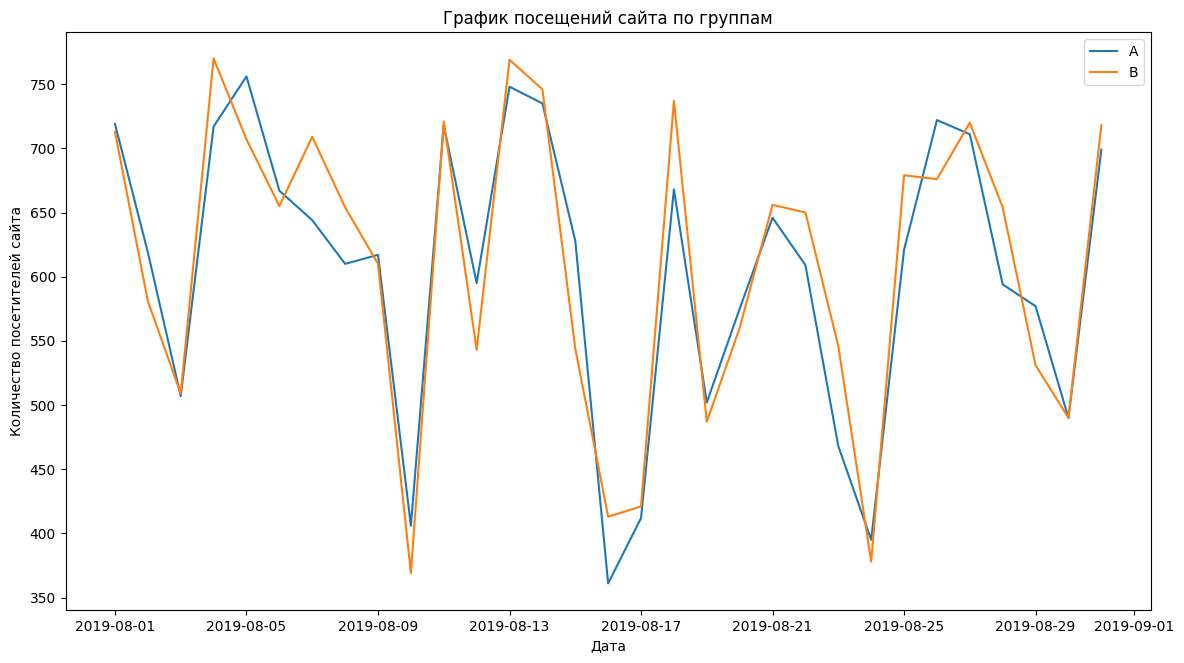

In [36]:
visits_A = visits[visits['group'] == 'A']
visits_B = visits[visits['group'] == 'B']

plt.figure(figsize=(14, 7.5))
plt.plot(visits_A['date'], visits_A['visitors'], label='A')
plt.plot(visits_B['date'], visits_B['visitors'], label='B')
plt.title('График посещений сайта по группам')
plt.xlabel('Дата')
plt.ylabel('Количество посетителей сайта')
plt.legend();

**Вывод:** Распределение посетителей сайта по группам осуществлялось относительно корректно.Незначительные расхождения в графиках вероятнее всего вызваны повторными посещениями сайта ранее зафиксированными пользователями.

##### Вывод: 
Предварительная оценка данных показала следующие результаты:
1.  А/В_тестирование проводилось в период  1 по 31 августа 2019 года. Фиксация посещений сайта и оформления заказов осуществлялась в указанные сроки.
2. При проведении А/В-теста пользователи были поделены на две группы: А и В.
3. Распределение посетителей сайта по группам осуществлялось относительно корректно. Незначительные расхождения в графиках посещения сайта вероятнее всего вызваны повторными посещениями сайта ранее зафиксированными пользователями.
4. Так как информация о посещениях пользователями сайта представлена в виде сводной таблицы, оценить количественное распределение пользователей по группам не представляется возможным. Оценка произведена по количеству пользователей, совершивших покупку. По результатам чего установлено, что за время проведения А/В-теста 1031 пользователь совершил покупку в интернет магазине. При этом платящих пользователей в группе B оказалось больше(586 против 503). Кроме того 58 пользователей попали в обе группы. 

Посещения и заказы пользователей, попавших в обе группы, следовало бы удалить. Однако в таблице с посещениями указано только общее количество посещений пользователей  каждой из групп в конкретную дату. И ее откорректировать, исключив посещения дублированных пользователей, мы не можем. Поэтому  исказилось бы значение  показателя "Среднее количество заказов на посетителя"(в меньшую сторону), так как в знаменателе посещения этих пользователей остались бы.  
Строки не удаляем.

#### Анализ кумулятивных метрик

##### Подготовка кумулятивных данных

In [40]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [37]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

Проверим корректность создания датафрейма. Выведем первые пять строк, а также сопоставим даты, указанные в нем с датами проведения А/В-теста.

In [38]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [39]:
print(f'Минимальная дата: {cumulativeData.date.dt.date.min()}', 
      f'Максимальная дата: {cumulativeData.date.dt.date.max()}', sep = '\n')

Минимальная дата: 2019-08-01
Максимальная дата: 2019-08-31


**Вывод:** Датафрейм сформирован корректно. Минимальная и максимальная даты совпадают с датами проведения анализа.

##### Построение и анализ графика кумулятивной выручки по группам

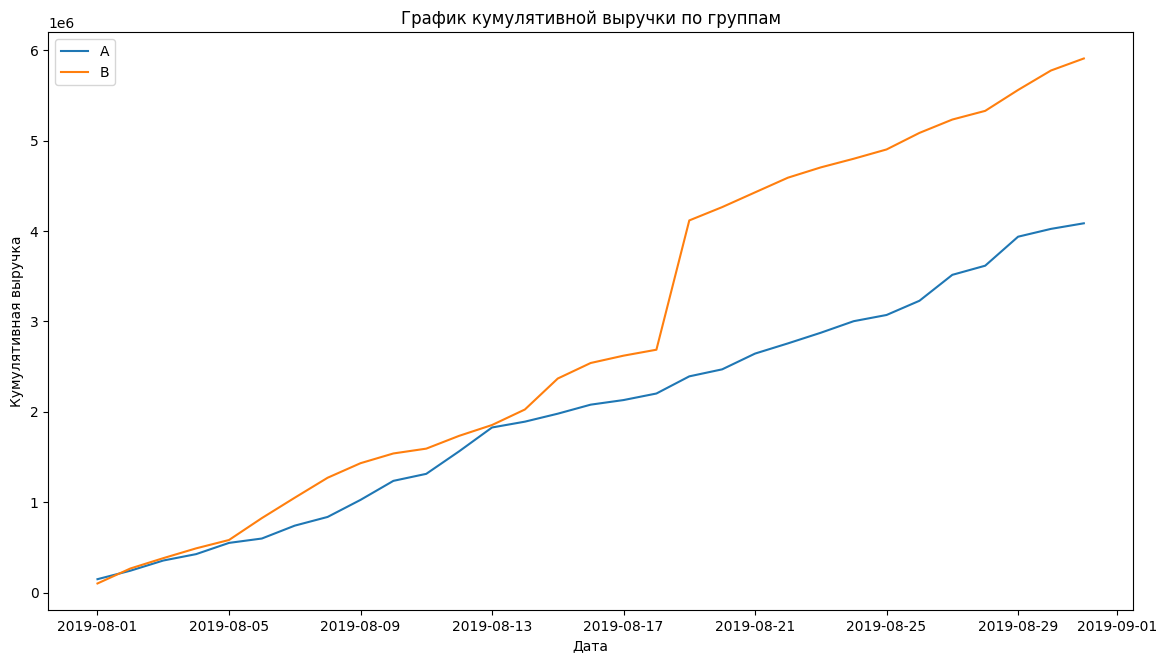

In [41]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]

plt.figure(figsize=(14, 7.5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
#plt.grid(b=True)
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.title('График кумулятивной выручки по группам')
plt.legend();

**Вывод:** Кумулятивная выручка по группе B практически на всем протяжении теста больше, чем у группы A. Это может быть вызвано как более высоким средним чеком у пользователей из группы B, так большим количеством оформленных данными пользователями заказов(большей конверсией из посетителей в покупатели).  
При этом в районе 19.08.2021 наблюдается резкий скачок кумулятивной выручки группы B, что может свидетельствовать либо об  оформлении аномального дорогого заказа либо о сравнительно большом количестве оформленных заказов в эту дату.

#####  Построение и анализ графика кумулятивного среднего чека по группам

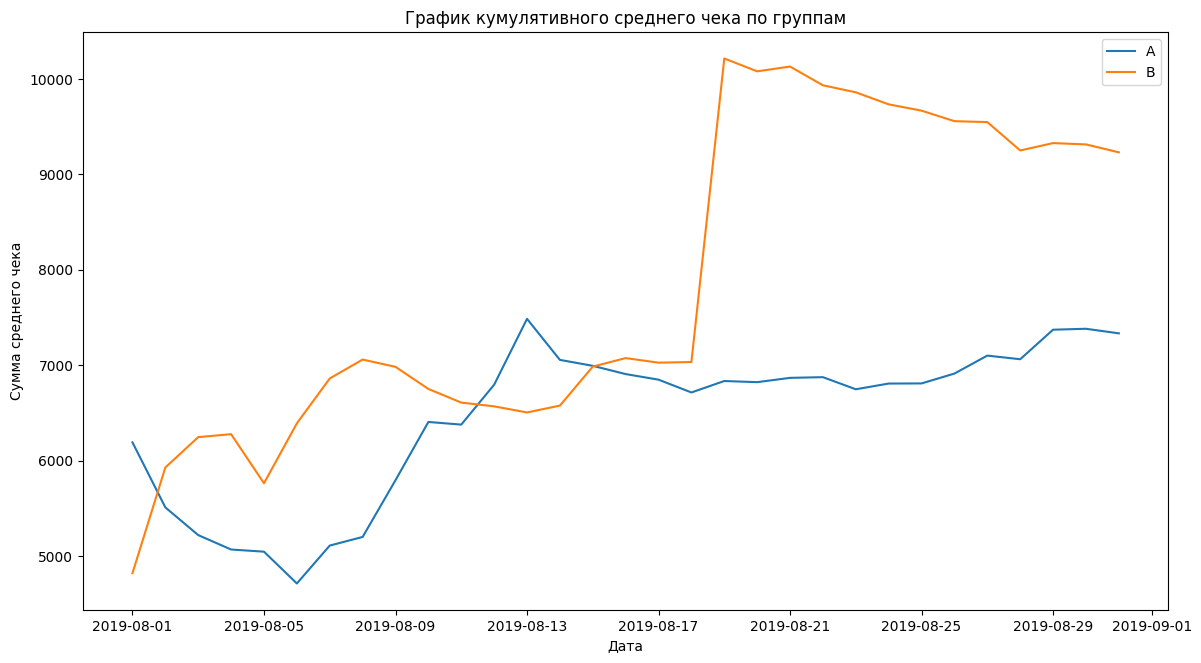

In [42]:
plt.figure(figsize=(14, 7.5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
#plt.xticks(rotation = 60)
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.legend();

**Вывод:** Кумулятивный средний чек по группе А в первую неделю тестирования снижается, в последующем имеет тенденцию к росту, относительно стабилизировавшись с тетьей недели тестирования.  
Кумулятивный средний чек по группе B первые 2 недели тестирования растет, в последующем наблюдается резкий скачок, что может быть вызвано аномально дорогим заказом.
Тенденция к снижению среднего чека в конце тестирования вызвана его стремлением к нормальному значению после резкого роста в взязи с возможным аномально дорогим заказом.

##### Построение и анализ графика относительного изменения кумулятивного среднего чека группы B к группе A. 


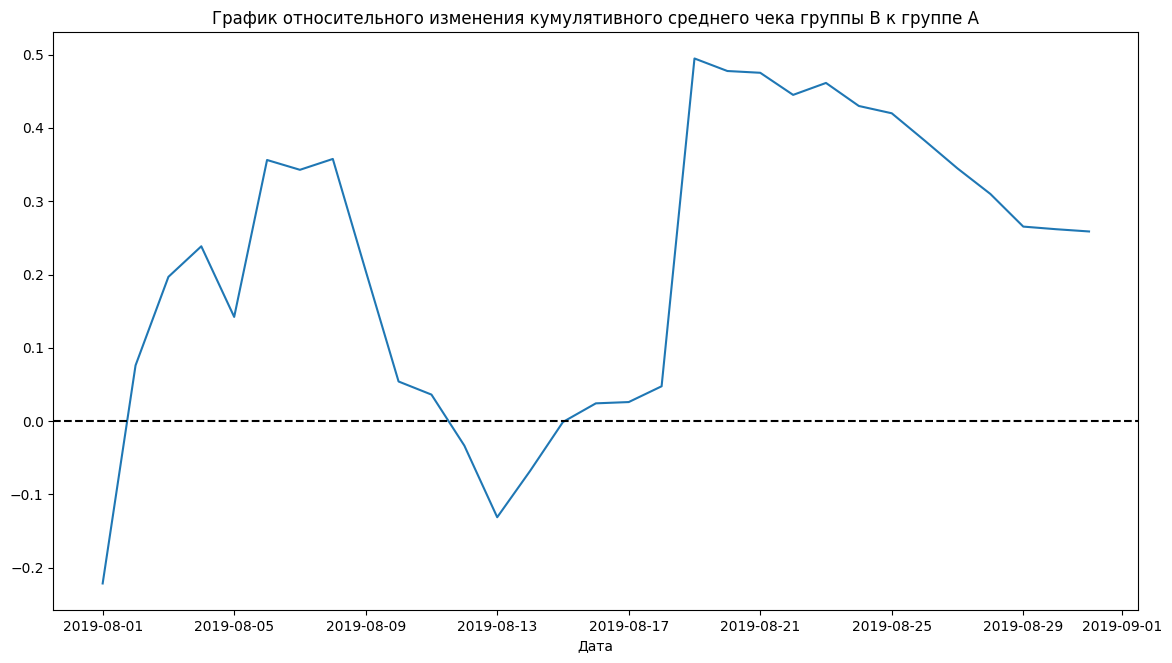

In [43]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(14, 7.5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата');



**Вывод:** В целом значение среднего чека у группы B практически в весь период тестирования выше аналогичного показателя группы А, за исключением нескольких дней в начале тестирования и в период с 11.08.2021 по 15.08.2021.

#####  Построение и анализ графика кумулятивного среднего количества заказов на посетителя по группам


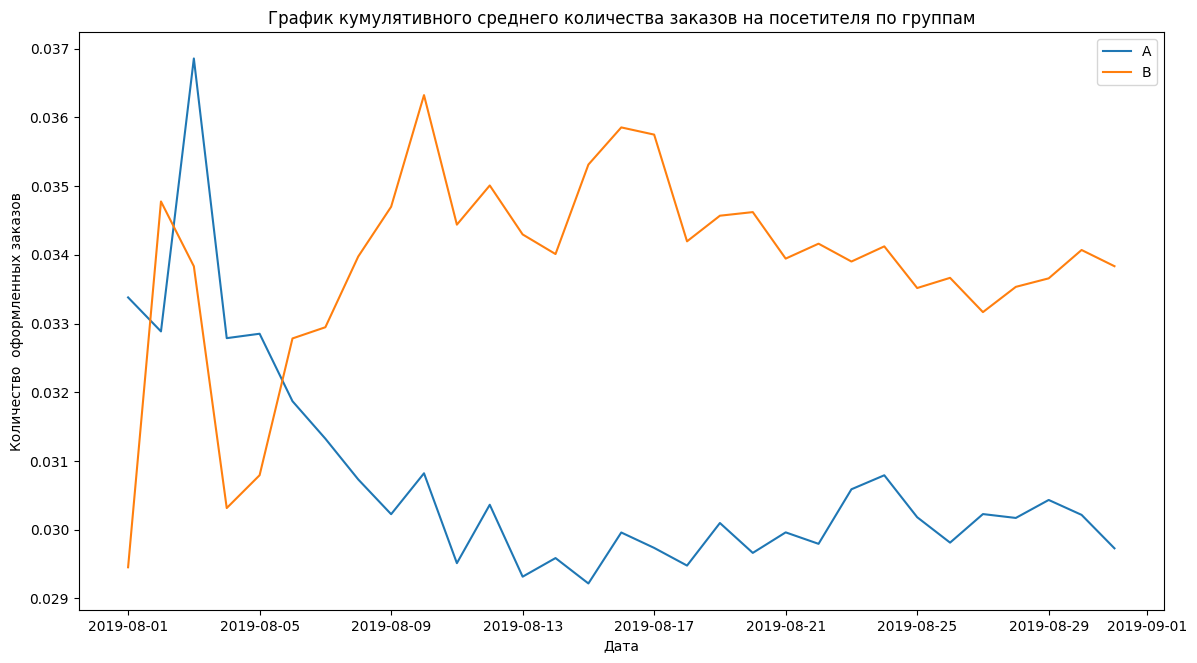

In [44]:
cumulativeBA = cumulativeData[cumulativeData['group'] == 'A'][['date','orders', 'visitors']]
cumulativeBB = cumulativeData[cumulativeData['group'] == 'B'][['date','orders', 'visitors']]
plt.figure(figsize=(14, 7.5))
plt.plot(cumulativeBA['date'], cumulativeBA['orders']/cumulativeBA['visitors'], label='A')
plt.plot(cumulativeBB['date'], cumulativeBB['orders']/cumulativeBB['visitors'], label='B')
#plt.xticks(rotation = 60)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Количество  оформленных заказов')
plt.legend();

**Вывод:** В целом значение среднего количества заказов на посетителя у каждой из групп относительно стабильно, при этом у группы В оно заметно выше(примерно на 0,5%).

Также ярко выражены скачки в среднем количесве оформленных заказов в начале месяца у обеих из исследуемых групп. Это может быть вызвано рядом причин, как поступлением востребовнного среди пользователей товара, так и большей платежеспособностью пользователей в этот период(у некоторых организаций в начале месяца выдают заработную плату).

#####  Построение и анализ графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A


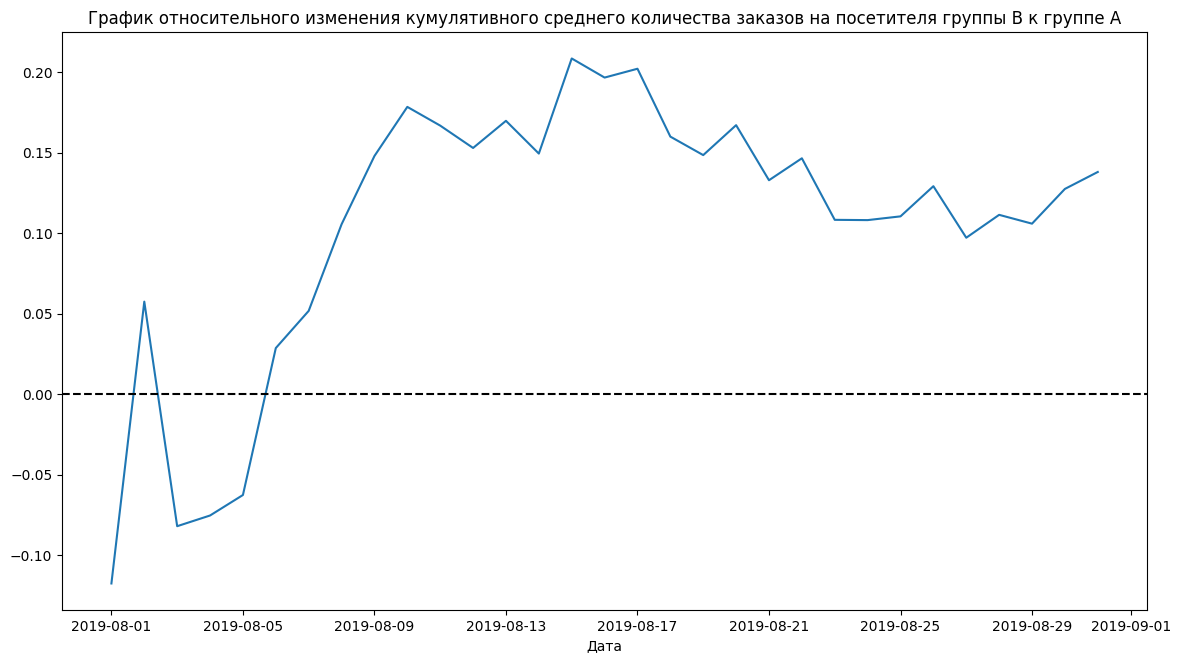

In [45]:
mergedcumulativeB = cumulativeBA.merge(cumulativeBB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(14, 7.5))
plt.plot(mergedcumulativeB['date'], (mergedcumulativeB['ordersB']/mergedcumulativeB['visitorsB'])/(mergedcumulativeB['ordersA']/mergedcumulativeB['visitorsA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата');

**Вывод:** В целом значение за весь период тестирования(за исключением первой недели) среднее количество заказов на посетителя у группы В выше на 10-15%, относительно группы А.

#####  Вывод:  
Анализ кумулятивных  метрик показал, что у группы В выше показатель среднего количества заказов на посетителя, чем у группы A, что положительно сказывается на значении показателя кумулятивной выручки.  
Значение кумулятивного среднего чека и кумулятивной выручки у группы B также выше относительно группы А. Однако на это может влиять аномально дорогой заказ, оформленный 19.08.2021. 
Имеется целесообразность рассмотреть значение данных метрик после исключения аномально больших значений.

#### Анализ выбросов

##### Анализ количества заказов по пользователям

######  Построение и анализ точечного графика количества заказов по пользователям.


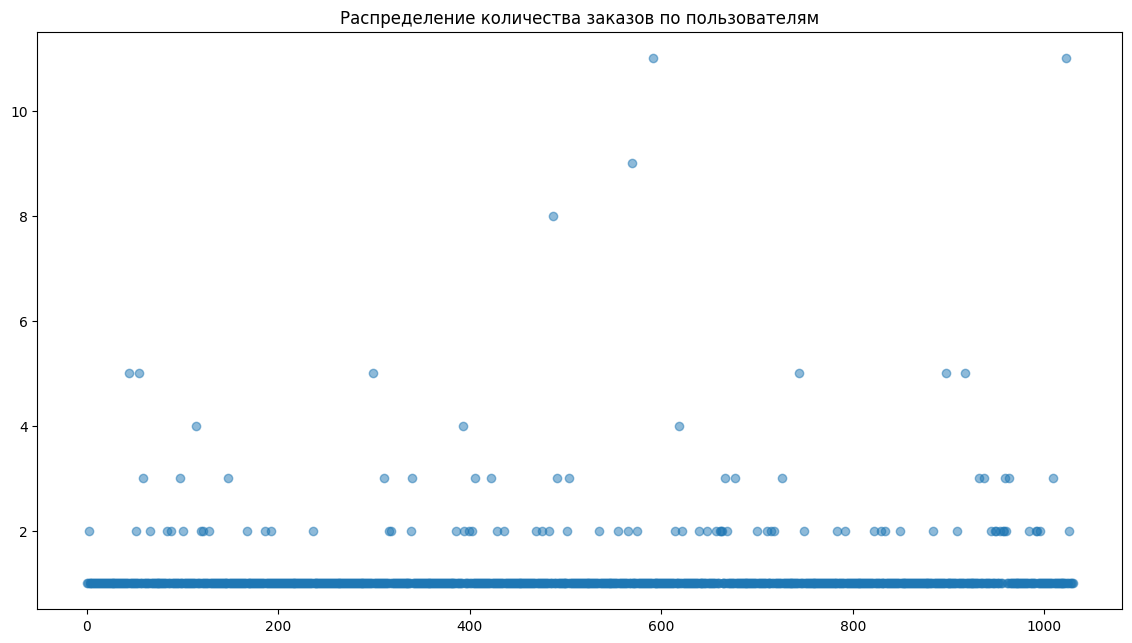

In [46]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(14, 7.5))
plt.scatter(x_values, ordersByUsers['transaction_id'], alpha = 0.5)
plt.title('Распределение количества заказов по пользователям'); 

**Вывод:** Большинство пользователей за период тестирования оформили 1-2 заказа, меньше - 4-6 заказов. При этом имеются пользователи, оформившие 8-12 заказов. Для определения границы аномальных значений целесообразно расчитать 95 и 99 перцентили количества заказов.

###### Расчет 95-й и 99-й перцентили количества заказов на пользователя

In [47]:
per_ord_95, per_ord_99 = np.percentile(ordersByUsers['transaction_id'], [95, 99])
print(f'95-й перцентиль количества заказов по пользователям - {round(per_ord_95)} заказа',
     f'99-й перцентиль количества заказов по пользователям - {round(per_ord_99)} заказа', sep = '\n')

95-й перцентиль количества заказов по пользователям - 2 заказа
99-й перцентиль количества заказов по пользователям - 4 заказа


**Вывод:** 99 % пользователей оформили 4 и менее заказов. Аномальными считаем пользователей, оформивших более 4 заказов за период тестирования.

##### Анализ стоимостей заказов

######  Построение и анализ точечного  графика стоимостей заказов


Построим точечный график распределдения стоимостей заказов.

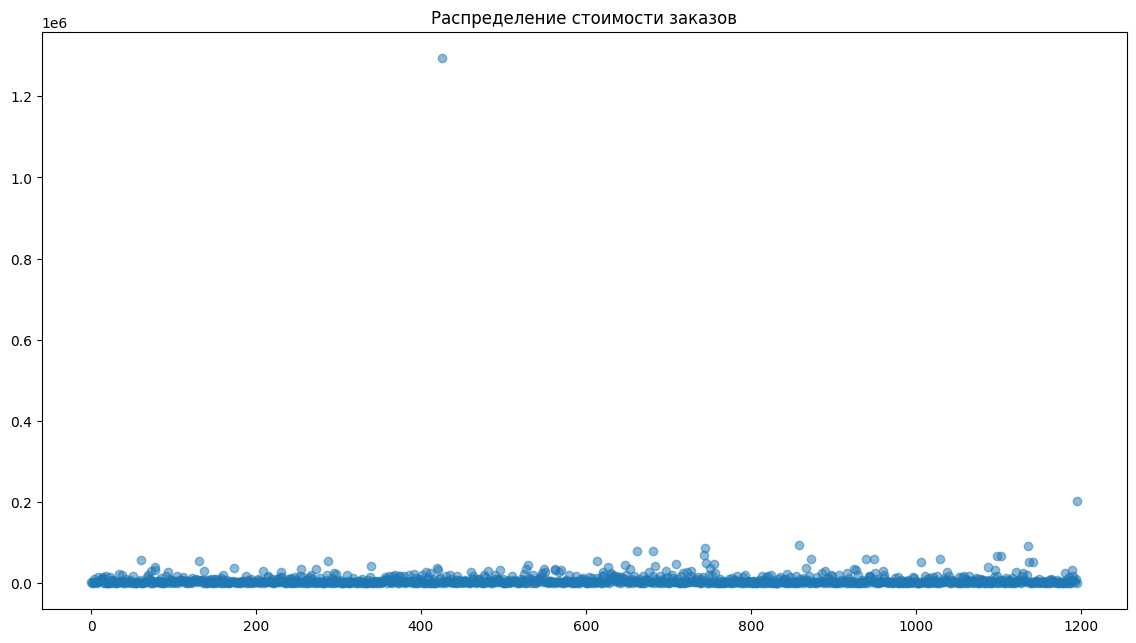

In [48]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(14, 7.5))
plt.scatter(x_values, orders['revenue'], alpha = 0.5)
plt.title('Распределение стоимости заказов');

Дополнительно построим график распределениябез учета откровенно выбивающихся по стоимсти заказов.

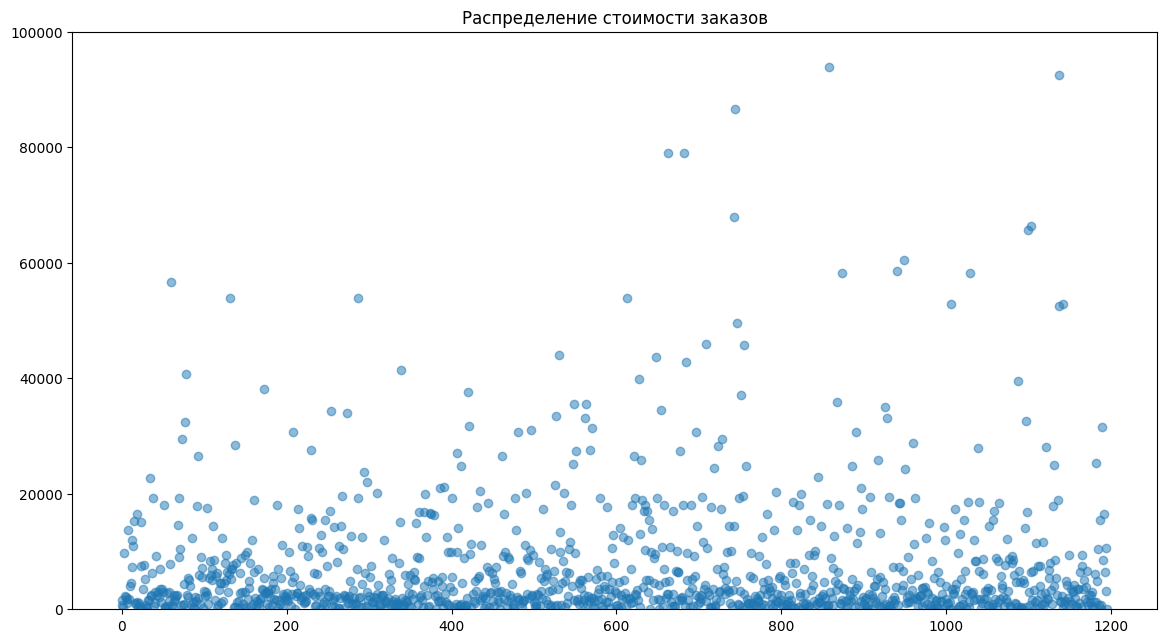

In [49]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(14, 7.5))
plt.scatter(x_values, orders['revenue'], alpha = 0.5)
plt.ylim([0,100000])
plt.title('Распределение стоимости заказов');

**Вывод:** Стоимость большинства заказов менее 50 тыс. условных единиц, при этом имеется откровенный выброс - заказ стоимостью практически 1,3 млн условных единиц.Для определения границы аномальных значений целесообразно расчитать 95 и 99 перцентили стоимости заказов.

###### Расчет 95-й и 99-й перцентили  стоимости заказов

In [50]:
per_rev_95, per_rev_99 = np.percentile(orders['revenue'], [95, 99])
print(f'95-й перцентиль стоимости заказов - {round(per_rev_95,2)} условных единиц',
     f'99-й перцентиль стоимости заказов - {round(per_rev_99,2)} условных единиц', sep = '\n')


95-й перцентиль стоимости заказов - 28000.0 условных единиц
99-й перцентиль стоимости заказов - 58233.2 условных единиц


**Вывод:** Стоимость 99 %  заказов не превышает 58233.2 условных единиц. Аномальными считаем более дорогие заказы.

##### Вывод:
Принято решение определения границ аномальных значений по 99 перцентилю каждого показателя. Аномальными считаем пользователей, оформивших более 4 заказов, а также заказы стоимостью более 58233,2 условных единиц.

#### Расчет статистической значимости различий 

##### Cтатистическая значимость различий по сырым данным

###### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по сырым данным

Сформулируем гипотезы: 

*H_0:* Среднее количестве заказов, оформленных пользователями из группы A = Среднее количестве заказов, оформленных пользователями из группы B`

*H_1:* Среднее количестве заказов, оформленных пользователями из группы A ≠ Среднее количестве заказов, оформленных пользователями из группы B`  

Уровень статистической значимости - alpha = 0.05

In [51]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits_A['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits_B['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print(f'p_value: {"{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1])}')
print(f'различие в средних значениях: {"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)}')

p_value: 0.017
различие в средних значениях: 0.138


**Вывод:** 
    p_value гораздо меньше 0.05. Имеются основания, чтобы отвергнуть нулевую гипотезу.
    Статистически средние значения количества заказов на посетителя между группами различаются.
    В группе В оформляется практически на 14% заказов больше относительно группы А.

###### Статистическая значимость различий в среднем чеке заказа между группами  по сырым данным

Сформулируем гипотезы: 

*H_0:* Средний чек заказов, оформленных пользователями из группы A = Средний чек заказов, оформленных пользователями из группы B`

*H_1:* Средний чек заказов, оформленных пользователями из группы A ≠ Средний чек заказов, оформленных пользователями из группы B`  

Уровень статистической значимости - alpha = 0.05

In [52]:
print(f'p_value: {"{0:.3f}".format(st.mannwhitneyu(orders[orders["group"]=="A"]["revenue"],orders[orders["group"]=="B"]["revenue"])[1])}')
print(f'различие в средних значениях: {"{0:.3f}".format(orders[orders["group"]=="B"]["revenue"].mean()/orders[orders["group"]=="A"]["revenue"].mean()-1)}')

p_value: 0.729
различие в средних значениях: 0.259


**Вывод:** p_value гораздо больше 0.05. Оснований, чтобы отвергнуть нулевую гипотезу, нет. Статистически средние среднего чека между группами не различаются. При этом средний чек в группе В практически на 26% больше относительно среднего чека группы А, что может быть вызвано наличием аномально дорогих заказов.

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊<a class="tocSkip"> </h2>
Правильно)

##### Cтатистическая значимость различий по "очищенным" данным

Сформируем список "аномальных" пользователей 

In [53]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > per_ord_99]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > per_ord_99]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > per_rev_99]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(f'Количесво "аномальных" пользователей: {abnormalUsers.shape[0]}')
print('Доля "аномальных" пользователей от общего количества: ', \
      "{0:.2%}".format(abnormalUsers.shape[0]/orders['visitor_id'].nunique()))

Количесво "аномальных" пользователей: 15
Доля "аномальных" пользователей от общего количества:  1.45%


######  Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.


Сформулируем гипотезы: 

*H_0:* Среднее количестве заказов, оформленных пользователями из группы A = Среднее количестве заказов, оформленных пользователями из группы B`

*H_1:* Среднее количестве заказов, оформленных пользователями из группы A ≠ Среднее количестве заказов, оформленных пользователями из группы B`  

Уровень статистической значимости - alpha = 0.05

In [54]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits_A['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits_B['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print(f'p_value: {"{0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])}')
print(f'различие в средних значениях: {"{0:.2f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)}')

p_value: 0.014
различие в средних значениях: 0.15


**Вывод:** Кардинального различия по сравнению с сырыми данными не наблюдается.
    p_value также гораздо меньше 0.05. Имеются основания, чтобы отвергнуть нулевую гипотезу.
    Статистически средние значения количества заказов на посетителя между группами различаются.
    В группе В оформляется более чем на 15% заказов больше относительно группы А.

###### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы: 

*H_0:* Средний чек заказов, оформленных пользователями из группы A = Средний чек заказов, оформленных пользователями из группы B`

*H_1:* Средний чек заказов, оформленных пользователями из группы A     Средний чек заказов, оформленных пользователями из группы B`  

Уровень статистической значимости - alpha = 0.05

In [55]:
a_orders = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue']
b_orders = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue']

print(f'p_value: {"{0:.3f}".format(st.mannwhitneyu(a_orders,b_orders)[1])}')
print(f'различие в средних значениях: {"{0:.3f}".format(a_orders.mean()/b_orders.mean() - 1)}')
        

p_value: 0.851
различие в средних значениях: 0.006


**Вывод:** Анализ очищенных данных слегка подкорректировал результаты анализа.
p_value также гораздо больше 0.05. Оснований, чтобы отвергнуть нулевую гипотезу, нет. Статистически  значения среднего чека заказов между группами не различаются. 
При этом в сравнении с сырыми данными значительно изменилось соотшошение среднего чека между группами: значение среднего сека практически идентично(средний чек в группе В на 0,6% меньше относительно среднего чека группы А).

####  Принятие решений по результатам теста 

#####  Построение графиков  кумулятивных метрик на очищенных данных

Для принятия решения о целесобразности продолжения A/B-тестировния построим графики кумулятивных метрик на очищенных данных.

Подготовим данные.

In [56]:
orders_act = orders.query('visitor_id not in @abnormalUsers')
datesGroups_2 = orders_act[['date', 'group']].drop_duplicates()

ordersAggregated_2 = datesGroups_2.apply(
    lambda x: orders_act[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitsAggregated_2 = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData_2 = ordersAggregated_2.merge(
    visitsAggregated_2, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData_2.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

###### График кумулятивной выручки по группам

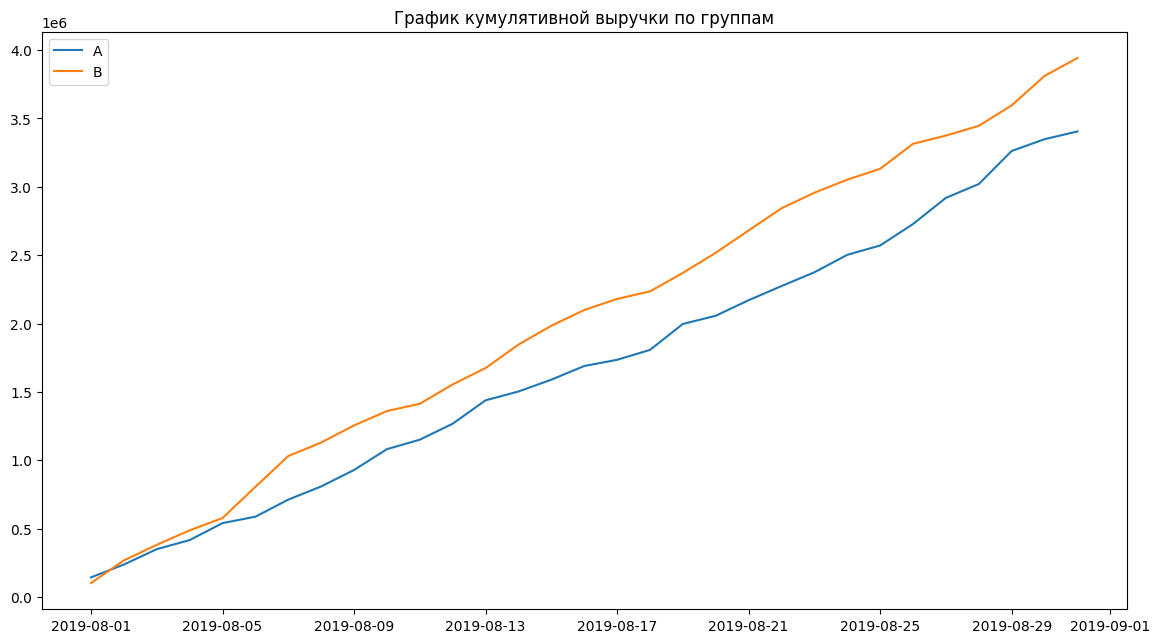

In [57]:
cumulativeRevenueA_2 = cumulativeData_2[cumulativeData_2['group'] == 'A'][['date','revenue', 'orders']]
cumulativeRevenueB_2 = cumulativeData_2[cumulativeData_2['group'] == 'B'][['date','revenue', 'orders']]

plt.figure(figsize=(14, 7.5))
plt.plot(cumulativeRevenueA_2['date'], cumulativeRevenueA_2['revenue'], label='A')
plt.plot(cumulativeRevenueB_2['date'], cumulativeRevenueB_2['revenue'], label='B')
#plt.grid(b=True)
plt.title('График кумулятивной выручки по группам')
plt.legend();

**Вывод:** Кумулятивная выручка по группе B практически на всем протяжении теста больше, чем у группы A. Резкие колебания по обоим графикам отсутствуют.  

######  График кумулятивного среднего чека по группам

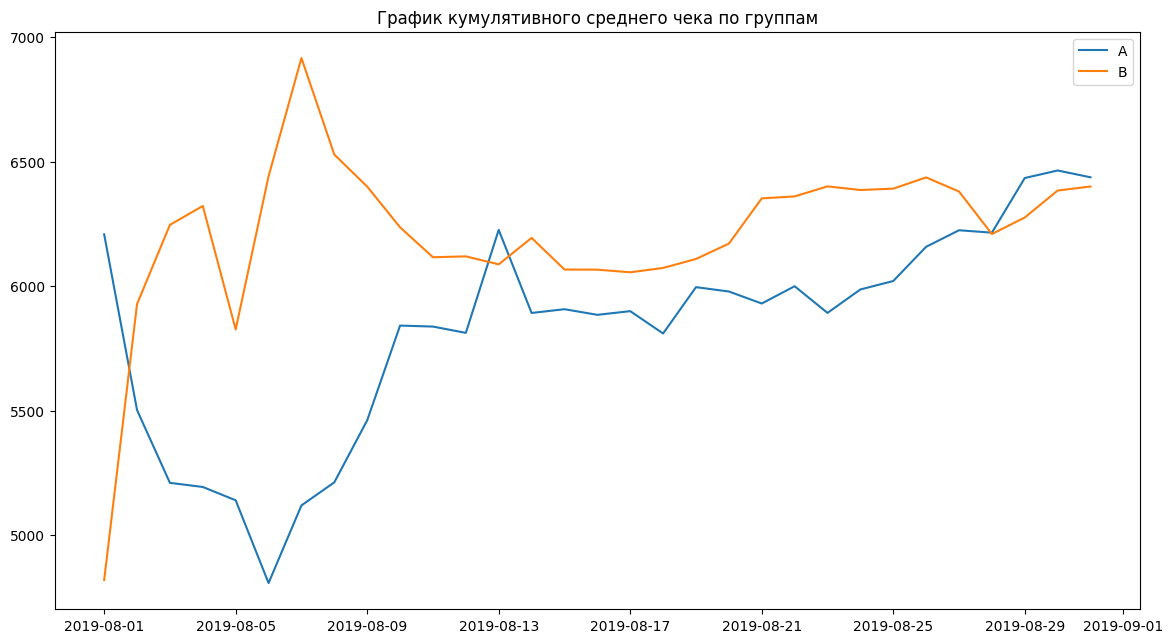

In [58]:
plt.figure(figsize=(14, 7.5))
plt.plot(cumulativeRevenueA_2['date'], cumulativeRevenueA_2['revenue']/cumulativeRevenueA_2['orders'], label='A')
plt.plot(cumulativeRevenueB_2['date'], cumulativeRevenueB_2['revenue']/cumulativeRevenueB_2['orders'], label='B')
#plt.xticks(rotation = 60)
plt.title('График кумулятивного среднего чека по группам')
plt.legend();

**Вывод:** Кумулятивный средний чек по группе А в первую неделю тестирования снижается, в последующем имеет тенденцию к росту, относительно стабилизировавшись с третьей недели тестирования.  
Кумулятивный средний чек по группе B первую  неделю тестирования растет, в последующем относительно стабилизировался с незначительными колебаниями.

###### График относительного изменения кумулятивного среднего чека группы B к группе A

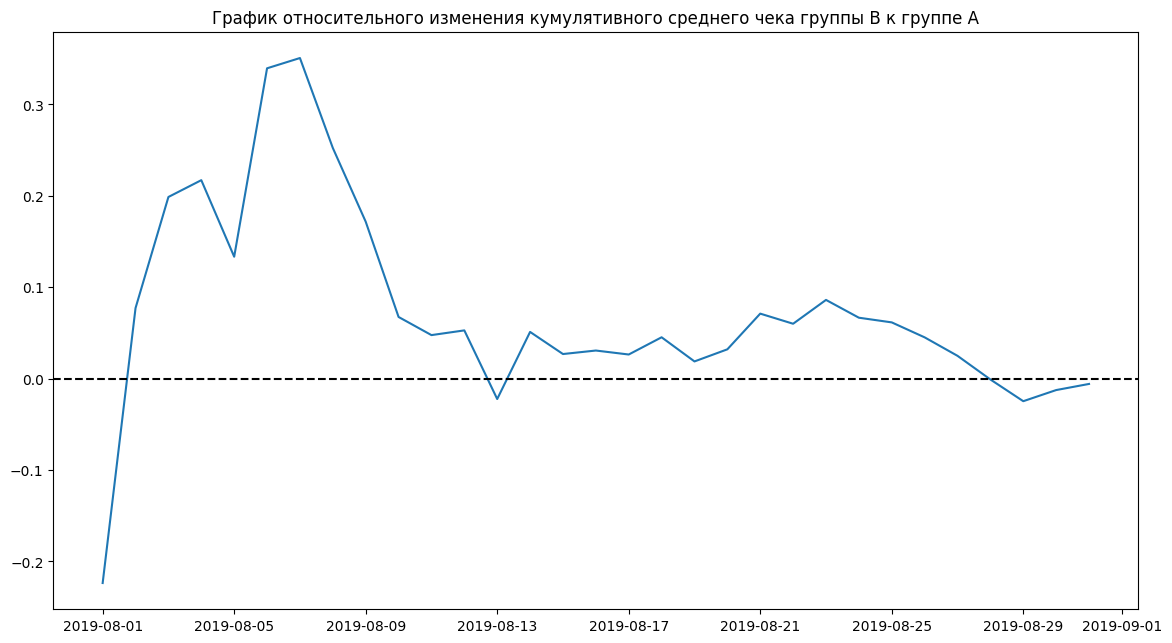

In [59]:
mergedCumulativeRevenue_2 = cumulativeRevenueA_2.merge(cumulativeRevenueB_2, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(14, 7.5))
plt.plot(mergedCumulativeRevenue_2['date'], (mergedCumulativeRevenue_2['revenueB']/mergedCumulativeRevenue_2['ordersB'])/(mergedCumulativeRevenue_2['revenueA']/mergedCumulativeRevenue_2['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A');
#plt.xticks(rotation = 60)

**Вывод:** Практически все время тестирования значение кумулятивного среднего чека про группе В превышает превышает аналогичное значение группы А. На момент окончания тестирования кумулятивный средний чек по группам практически выровнялся.

###### График кумулятивного среднего количества заказов на посетителя по группам

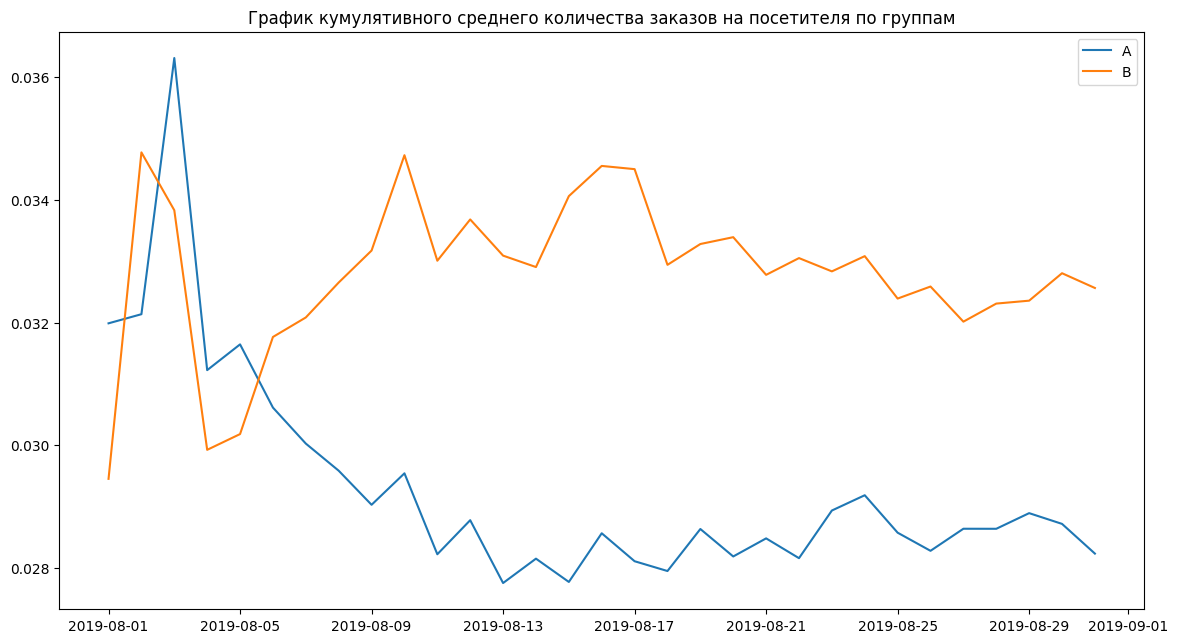

In [60]:
cumulativeBA_2 = cumulativeData_2[cumulativeData_2['group'] == 'A'][['date','orders', 'visitors']]
cumulativeBB_2 = cumulativeData_2[cumulativeData_2['group'] == 'B'][['date','orders', 'visitors']]
plt.figure(figsize=(14, 7.5))
plt.plot(cumulativeBA_2['date'], cumulativeBA_2['orders']/cumulativeBA_2['visitors'], label='A')
plt.plot(cumulativeBB_2['date'], cumulativeBB_2['orders']/cumulativeBB_2['visitors'], label='B')
#plt.xticks(rotation = 60)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.legend();

**Вывод:** В целом, начиная со второй недели тестирования, значение среднего количества заказов на посетителя у каждой из групп относительно стабильно, при этом у группы В оно заметно выше(примерно на 0,5%).

######  График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

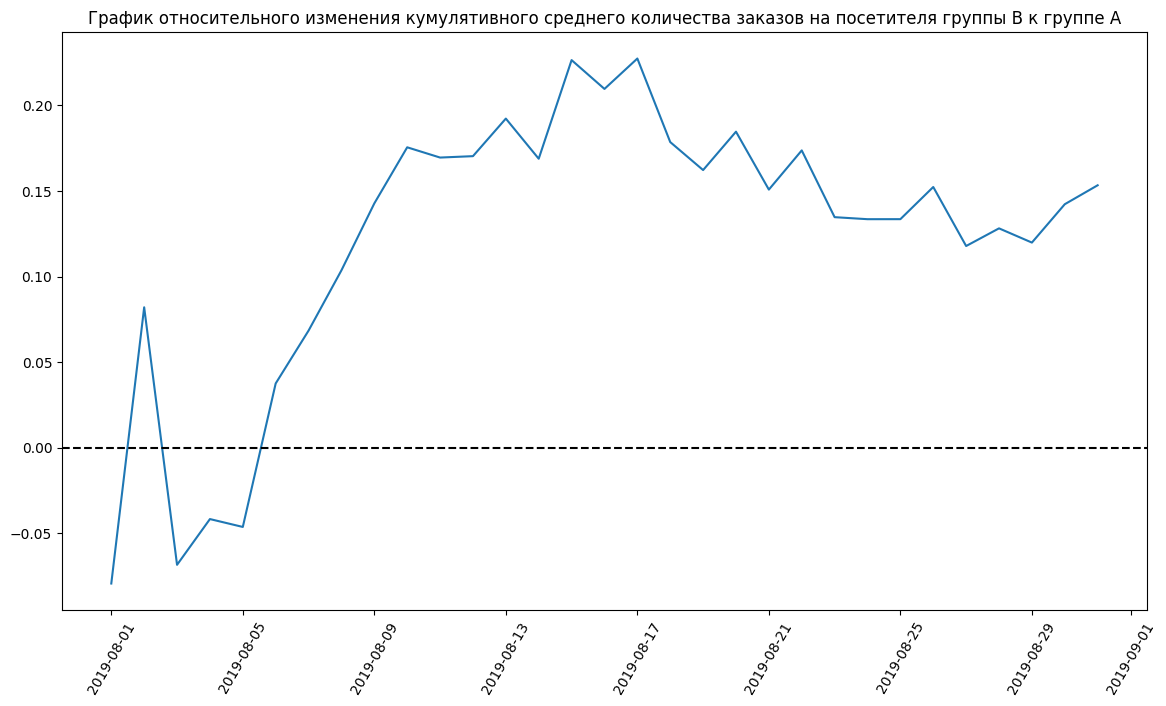

In [61]:
mergedcumulativeB_2 = cumulativeBA_2.merge(cumulativeBB_2, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(14, 7.5))
plt.plot(mergedcumulativeB_2['date'], (mergedcumulativeB_2['ordersB']/mergedcumulativeB_2['visitorsB'])/(mergedcumulativeB_2['ordersA']/mergedcumulativeB['visitorsA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xticks(rotation = 60);

 **Вывод:** В целом значение за весь период тестирования(за исключением первой недели) среднее количество заказов на посетителя у группы В выше на 10-15%, относительно группы А.

#####  Решение по результатам теста

Так как значения кумулятивных метрик относительно стабильны, принято решение остановить тест.  
Зафиксировать победу группы В, так как зафиксированы статистически значимые различия кумулятивного среднего количества заказов на посетителя между тестируемыми группами. Значение данного показателя у группы В более чем на 15% выше относительно группы А, что находит свое отражение и в увеличении кумулятивной выручки.  
Значения кумулятивного среднего чека между группами статистически не различаются.

Можно определить, что внедряемые изменения влекут за собой увеличение конверсии пользователей из посетителей в покупатели, при этом влияние на значение среднего чека заказа не имеют.

### Вывод: 
Задачей проекта было приоретизация разработанных совместно с отделом маркетинга гипотез, и последующий анализ результатов проведенного A/B-тестирования по выбранной гипотезе.

В распоряжении имелись следующие данные:

1. Информация о выдвинутых гипотезах - датасет следующей структуры:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


2. Информация о заказах - датасет следующей структуры:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

3. Информация о посещениях сайта - датасет следующей структуры:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

В ходе предобработки данные были подготовлены для анализа. Датафреймы проверены на наличие пропусков и явных дубликатов. Наимоенования столбцов приведены в корректный вид. Откорректирован тип данных в столбцах с датами.

Проведена приоритезация гипотез в соответствие с фрейворками ICE и RICE, что  показало различные результаты. 
Это связано с тем, что в фреймворке RICE присутствует дополнительный компонент - "Reach"(скольких пользователей затронет изменение, которое вы хотите внести).  
Так, наиболее приорететная по фрейворку  ICE гипотеза "Запустить акцию, дающую скидку на товар в день рождения", по фрейворку RICE заняла только 5 место, так как скидка в день рождения будет действовать только однократно в течение года, и не все пользователи оформляют заказы в свой день рождения. Компонент "Reach" у данной гипотезы минимальный.  
Гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" наоборот, имеет максимальное значение компонента "Reach", так как затрагивает основную часть пользователей. Благодаря чему по фрейворку RICE данная гипотеза выбилась в абсолютные лидеры, хотя по фрейворку ICE занимала лишь третье место.

Анализ A/B-теста проводился в несколько этапов:
1. Предварительная оценка данных показала следующие результаты:
*  А/В_тестирование проводилось в период  1 по 31 августа 2019 года. Фиксация посещений сайта и оформления заказов осуществлялась в указанные сроки.
* При проведении А/В-теста пользователи были поделены на две группы: А и В.
* Распределение посетителей сайта по группам осуществлялось относительно корректно. Незначительные расхождения в графиках посещения сайта вероятнее всего вызваны повторными посещениями сайта ранее зафиксированными пользователями.
* Так как информация о посещениях пользователями сайта представлена в виде сводной таблицы, оценить количественное распределение пользователей по группам не представляется возможным. Оценка произведена по количеству пользователей, совершивших покупку. По результатам чего установлено, что за время проведения А/В-теста 1031 пользователь совершил покупку в интернет магазине. При этом платящих пользователей в группе B оказалось больше(586 против 503). Кроме того 58 пользователей попали в обе группы. 
2. Анализ кумулятивных  метрик на сырых данных показал, что у группы В выше показатель среднего количества заказов на посетителя, чем у группы A, что положительно сказывается на значении показателя кумулятивной выручки.  
Значение кумулятивного среднего чека  у группы B также выше относительно группы А. Однако на это большое влияние оказал аномально дорогой заказ, оформленный 19.08.2021. Было принято решение оценить значение данных метрик после исключения аномально больших значений.
3. В ходе анализа выбросов были построены точечные графики количества заказов на пользователя и стоимостей заказов, а также были рассчитаны 95 и 99 перцентили этих показателей.  
Принято решение считать аномальными значения, превышающие 99 перцентили по каждому из показателей. Доля "аномальных" пользователей от общего количества составила 1.45%.
4. Рассчет статистической значимости различий между группами как по сырым так и по очищенным данным показал похожите результаты:
* Имеются основания, чтобы отвергнуть нулевую гипотезу о равенстве средних значений количества заказов на посетителя. Статистически средние значения количества заказов на посетителя между группами различаются. В группе В оформляется более чем на 15% заказов больше относительно группы А.
*  Оснований, чтобы отвергнуть нулевую гипотезу о равенстве среднего чека заказов между группами, нет. Статистически значения среднего чека заказов между группами не различаются. 
Единственное различие, в сырых данных показзатель кумулятивного среднего чека заказов по группе В значительно превышает аналогичный показатель по группе А, ввиду наличия аномально дорогого заказа.
5. Построение графиков кумулятивных метрик по "очищенным" данным также показало, что у группы В выше показатели среднего количества заказов на посетителя и кумулятивной выручки, чем у группы A. Значения кумулятивного среднего чека между группами практически не различаются. Значения исследуемых метрик во вторую половину тестирования относительно стабильны.

По итогам проекта было принято решение решение остановить тест. Зафиксировать победу группы В, так как зафиксированы статистически значимые различия кумулятивного среднего количества заказов на посетителя между тестируемыми группами. Значение данного показателя у группы В более чем на 15% выше относительно группы А, что находит свое отражение и в увеличении кумулятивной выручки.  
Значения кумулятивного среднего чека между группами статистически не различаются.

Можно определить, что внедряемые изменения влекут за собой увеличение конверсии пользователей из посетителей в покупатели, при этом влияние на значение среднего чека заказа не имеют.